# Neural network based calibration of the rough Bergomi model
We calibrate the rough Bergomi model using the neural network trained in https://github.com/sigurdroemer/rough_volatility

### Import libraries and set directories
Start with setting the root directory so we can import utilities in other folders in this repo.

In [1]:
import sys
import os
from base_fns import get_local_folder

DIR = get_local_folder()
ROOTDIR = os.path.dirname(DIR)
sys.path.append(ROOTDIR)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

from NeuralNetworkPricing import NeuralNetworkPricer
from utils.svi import svi

### Define the model
Define neural network based (rough Bergomi) model.

In [3]:
weights_folder = DIR + "\\nn_weights"
contracts_folder = DIR
model = NeuralNetworkPricer(contracts_folder, weights_folder,"rbergomi")

### Target Vol Surface
Read the vol surface for 2005 Sep 09 (in SVI), and generate the target implied vols.

In [4]:
svi_file = ROOTDIR + "\\data\\spx_svi_2005_09_15.csv"
svi_df = pd.read_csv(svi_file, parse_dates=["date"])
expirations = list(svi_df["date"][1:-2])  # Skip the last two expirations

Generate SVI vols for a range of strikes, and remove those not in the domain for the NN.

In [5]:
logK = np.arange(-0.5, 0.5, 0.02)

k_orig = []
T_orig = []
k_obs = []
T_obs = []
iv_obs = []

for i, exp in enumerate(expirations):
    params = svi_df[svi_df["date"] == exp].iloc[0]

    k_cand = logK.reshape(-1, 1)
    t_cand = k_cand * 0 + params["texp"]
    idxKeep = model.AreContractsInDomain(k_cand, t_cand)
    k_obs_sub = k_cand[idxKeep,:]
    T_obs_sub = t_cand[idxKeep,:]

    w = svi(params, k_obs_sub)
    svi_iv_sub = np.sqrt(w / params["texp"])
    k_orig.extend(k_cand)
    T_orig.extend(t_cand)
    k_obs.extend(k_obs_sub)
    T_obs.extend(T_obs_sub)
    iv_obs.extend(svi_iv_sub)

Plot the strike and Terms of the contracts being used for calibration.

Original number of observations:  250
After filtering: 125


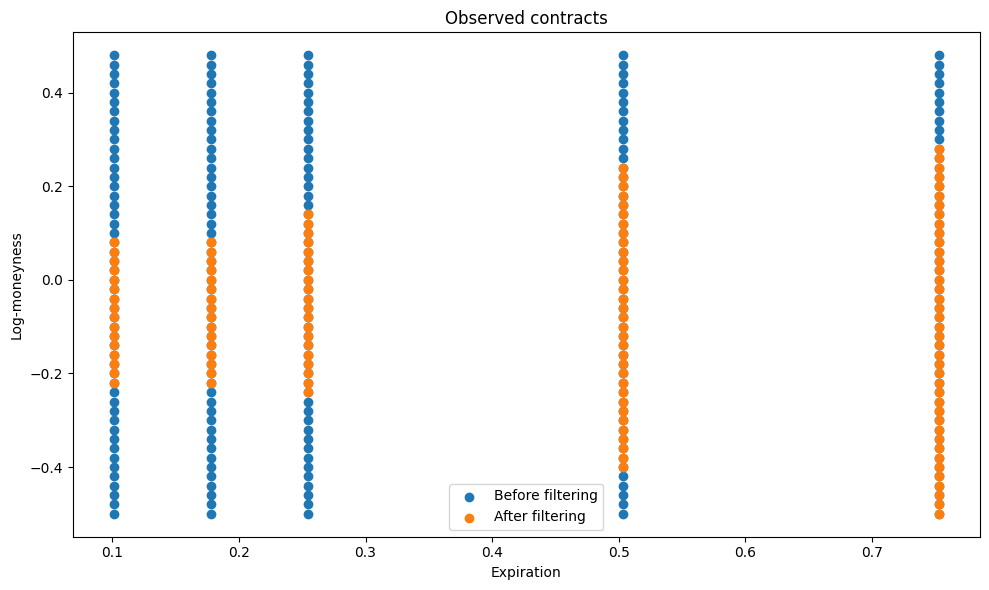

In [6]:
print("Original number of observations: ",len(k_orig))
print("After filtering:",len(k_obs))

# Plot contracts before and after filtering:
plt.figure(figsize=(10, 6))
plt.scatter(T_orig,k_orig,label="Before filtering")
plt.scatter(T_obs,k_obs,label="After filtering")
plt.title("Observed contracts")
plt.xlabel("Expiration")
plt.ylabel("Log-moneyness")
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
iv_obs = np.array(iv_obs).reshape(-1,1)
k_obs = np.array(k_obs).reshape(-1,1)
T_obs = np.array(T_obs).reshape(-1,1)

In [8]:
# model.Txi

### Calibrate the model using the NN.
Remark: In this version we force the forward variance curve (Xi) flat, which is params[3:]. This also avoids an overparameterised model.


In [9]:
# Set parameter bounds:
# Remark: Optimizer occassionally goes beyond the specified bounds. Thus we make the bounds slightly more narrow.
bounds = []
eps = pow(10, -6)
for i in range(0, len(model.lb)):
    bounds.append([model.lb[i] + eps, model.ub[i] - eps])

# Fix the forward variance curve flat:
bounds = bounds[0:4]
idxConvPar = np.concatenate((np.array([0, 1, 2]), 3 * np.ones(27))).astype(int)
print(idxConvPar)
par0 = np.array([0.2, 1.6, -0.7, pow(0.25, 2)])


# Define the error function:
def err_fun(parEval):
    return np.sum(
        pow(iv_obs - model.Eval(parEval[idxConvPar].reshape(-1, 1), k_obs, T_obs), 2)
    )


# Optimize:
res = minimize(err_fun, par0, method="L-BFGS-B", bounds=bounds)
print("Optimisation message: ", res.message)
parCalib = res.x[idxConvPar].reshape(-1, 1)

# Compare calibrated and true parameters:
print(parCalib.reshape(-1))

[0 1 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Optimisation message:  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[ 0.11323729  1.71616126 -0.71437993  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351
  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351  0.02165351]


### Plot the fit

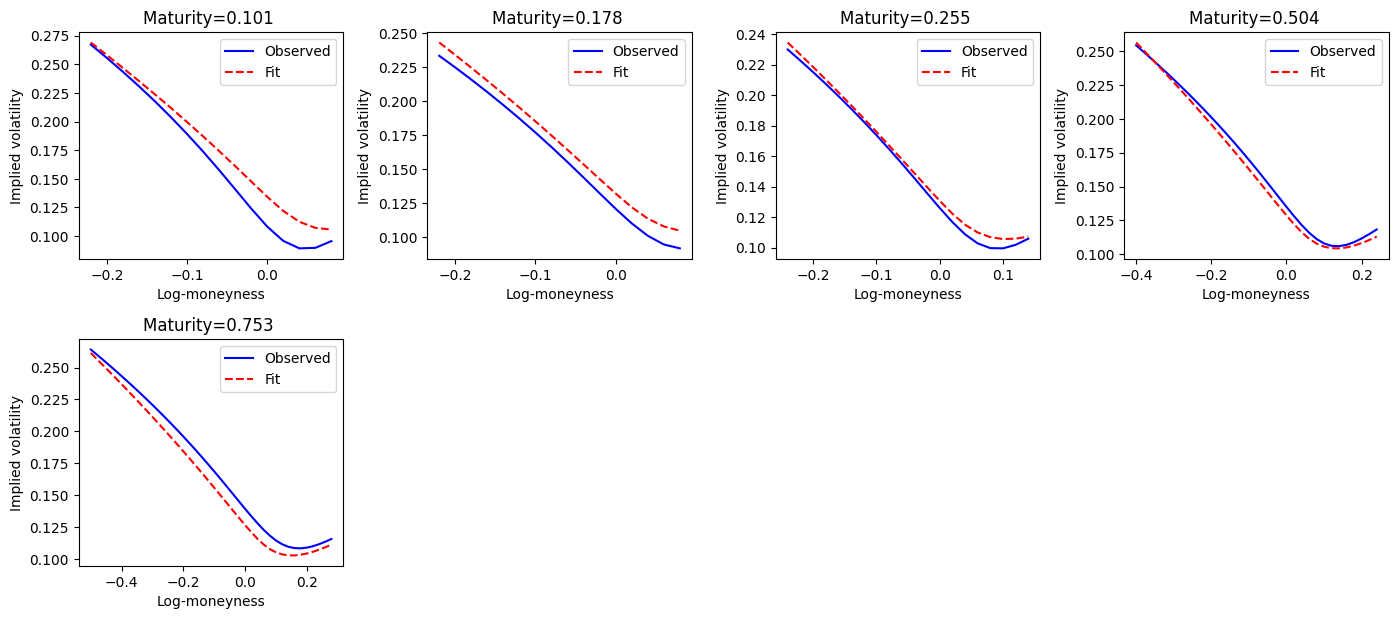

In [10]:
iv_fit = model.Eval(parCalib,k_obs,T_obs)

uniqT = np.unique(T_obs)
npts = 25
plt.figure(1,figsize=(14,12))
j = -1
iList = np.arange(0,len(uniqT))
for i in iList:
    j = j + 1
    plt.subplot(4,4,j+1)
    idxT = T_obs == uniqT[i]
    plt.plot(k_obs[idxT],iv_obs[idxT],'b',label='Observed')
    plt.plot(k_obs[idxT],iv_fit[idxT],'--r',label='Fit')
    plt.title("Maturity=%1.3f "%uniqT[i])
    plt.xlabel("Log-moneyness")
    plt.ylabel("Implied volatility")
    plt.legend()
plt.tight_layout()
plt.show()